In [1]:
import json

with open("../../data/gpt_4-1_nano/mmlu/original.json") as file:
    original_data = json.load(file)

with open("../../data/gpt_4-1_nano/mmlu/lexical/random.json") as file:
    random_data = json.load(file)

with open("../../data/gpt_4-1_nano/mmlu/lexical/synonym.json") as file:
    synonym_data = json.load(file)

with open("../../data/gpt_4-1_nano/mmlu/lexical/wrong_sense.json") as file:
    wrong_sense_data = json.load(file)

with open("../../data/gpt_4-1_nano/mmlu/lexical/worst_sense.json") as file:
    worst_sense_data = json.load(file)

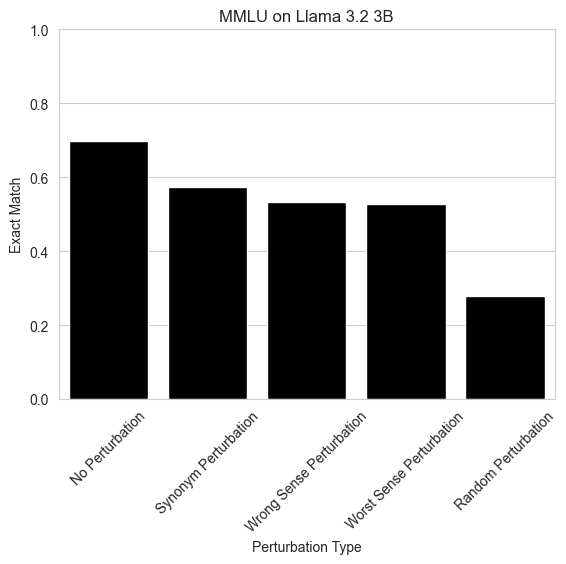

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

x_axis_labels = ["No Perturbation", "Synonym Perturbation", "Wrong Sense Perturbation", "Worst Sense Perturbation", "Random Perturbation"]
metrics = [
    original_data["metrics"]["exact_match"],
    synonym_data["metrics"]["exact_match"],
    wrong_sense_data["metrics"]["exact_match"],
    worst_sense_data["metrics"]["exact_match"],
    random_data["metrics"]["exact_match"]
]

barplot = sns.barplot(x=range(len(x_axis_labels)), y=metrics, color="black")
barplot.set_xticks(range(len(x_axis_labels)))
barplot.set_xticklabels(x_axis_labels, rotation=45)
plt.ylim(0, 1)
plt.xlabel("Perturbation Type")
plt.ylabel("Exact Match")
plt.title("MMLU on Llama 3.2 3B")
plt.show()

In [3]:
import pandas as pd

synonym_preds_df = pd.DataFrame.from_dict(synonym_data["predictions"])

with open("../../data/mmlu/lexical/synonym_perturbation.json") as file:
    synonym_data = json.load(file)

synonym_data_df = pd.DataFrame.from_dict(synonym_data["data"])

In [4]:
synonym_preds_df["question_metadata"] = synonym_data_df["question_metadata"]
synonym_preds_df["choice_metadata"] = synonym_data_df["choice_metadata"]
synonym_preds_df.head()

,dataset,question,answer,prediction,output,question_metadata,choice_metadata
0,abstract_algebra,Determine the level for the afforded field ext...,B,C,C,"{'n_synsets': [15, 0, 7, 0, 0, 43, 17, 12, 0, ...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'..."
1,abstract_algebra,"Allow P = (1, 2, 5, 4)(2, 3) in S_5 . Ascertai...",C,C,C) 24,"{'n_synsets': [6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'..."
2,abstract_algebra,Discover all nothings in the shown finite fiel...,D,C,C,"{'n_synsets': [15, 0, 4, 0, 0, 5, 2, 17, 0, 0,...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'..."
3,abstract_algebra,Statement 1 | A constituent grouping of a non-...,B,A,A,"{'n_synsets': [7, 0, 0, 0, 7, 3, 0, 0, 0, 0, 0...","[{'n_synsets': [2, 0, 2], 'n_lemmas': [0, 0, 0..."
4,abstract_algebra,Determine the mathematical product of the affo...,B,L,Let's analyze the problem step by step.\n\nGiv...,"{'n_synsets': [15, 0, 6, 0, 0, 43, 1, 0, 0, 43...","[{'n_synsets': [0, 0, 0], 'n_lemmas': [0, 0, 0..."


In [5]:
def sum_changed_tokens(row):
    n_changed_in_question = row.question_metadata["n_changed_tokens"]
    n_changed_in_choices = sum(choice["n_changed_tokens"] for choice in row.choice_metadata)

    return n_changed_in_question + n_changed_in_choices

synonym_preds_df["n_changed_tokens"] = synonym_preds_df.apply(sum_changed_tokens, axis=1)
synonym_preds_df.n_changed_tokens.describe()

count    14042.000000
mean        20.936761
std         23.038635
min          0.000000
25%          7.000000
50%         13.000000
75%         24.000000
max        255.000000
Name: n_changed_tokens, dtype: float64

In [6]:
def fraction_changed_tokens(row):
    n_changed_in_question = row.question_metadata["n_changed_tokens"]
    n_changed_in_choices = sum(choice["n_changed_tokens"] for choice in row.choice_metadata)

    n_content_in_question = row.question_metadata["n_content_tokens"]
    n_content_in_choices = sum(choice["n_content_tokens"] for choice in row.choice_metadata)

    if n_content_in_question + n_content_in_choices == 0:
        return 0

    return (n_changed_in_question + n_changed_in_choices) / (n_content_in_question + n_content_in_choices)


synonym_preds_df["fraction_changed_tokens"] = synonym_preds_df.apply(fraction_changed_tokens, axis=1)
synonym_preds_df.fraction_changed_tokens.describe()

count    14042.000000
mean         0.547485
std          0.156314
min          0.000000
25%          0.447368
50%          0.560000
75%          0.650000
max          1.000000
Name: fraction_changed_tokens, dtype: float64

In [7]:
def correct_prediction(row):
    return row.prediction == row.answer

synonym_preds_df["correct_prediction"] = synonym_preds_df.apply(correct_prediction, axis=1)
synonym_preds_df.correct_prediction.describe()

count     14042
unique        2
top        True
freq       8038
Name: correct_prediction, dtype: object

/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_68673/1044055334.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy = synonym_preds_df.groupby('token_bin')['correct_prediction'].mean().reset_index()


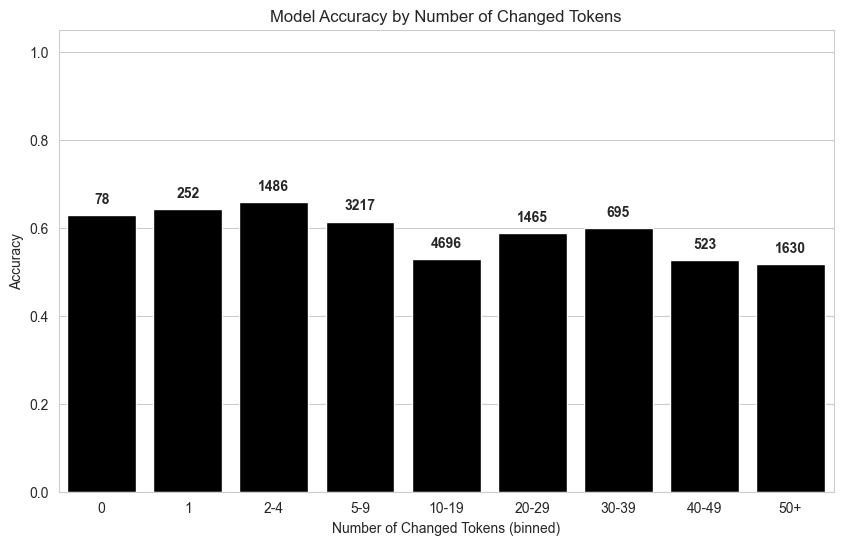

In [8]:
import numpy as np

# 1. Create bins for n_changed_tokens
bins = [0, 1, 2, 5, 10, 20, 30, 40, 50, np.inf]
labels = ['0', '1', '2-4', '5-9', '10-19', '20-29', '30-39', '40-49', '50+']
synonym_preds_df['token_bin'] = pd.cut(
    synonym_preds_df['n_changed_tokens'],
    bins=bins,
    labels=labels,
    right=False
)

# 2. Calculate accuracy per bin
bin_accuracy = synonym_preds_df.groupby('token_bin')['correct_prediction'].mean().reset_index()
# Calculate counts per bin
bin_counts = synonym_preds_df['token_bin'].value_counts().reindex(labels)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='token_bin', y='correct_prediction', data=bin_accuracy, color='black')

# Annotate counts on top of bars
for i, count in enumerate(bin_counts):
    ax.text(i, bin_accuracy['correct_prediction'][i] + 0.02, str(int(count)), 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Number of Changed Tokens (binned)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Number of Changed Tokens')
plt.ylim(0, 1.05)
plt.show()

/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_68673/988019953.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy = synonym_preds_df.groupby('fraction_bin')['correct_prediction'].mean().reset_index()


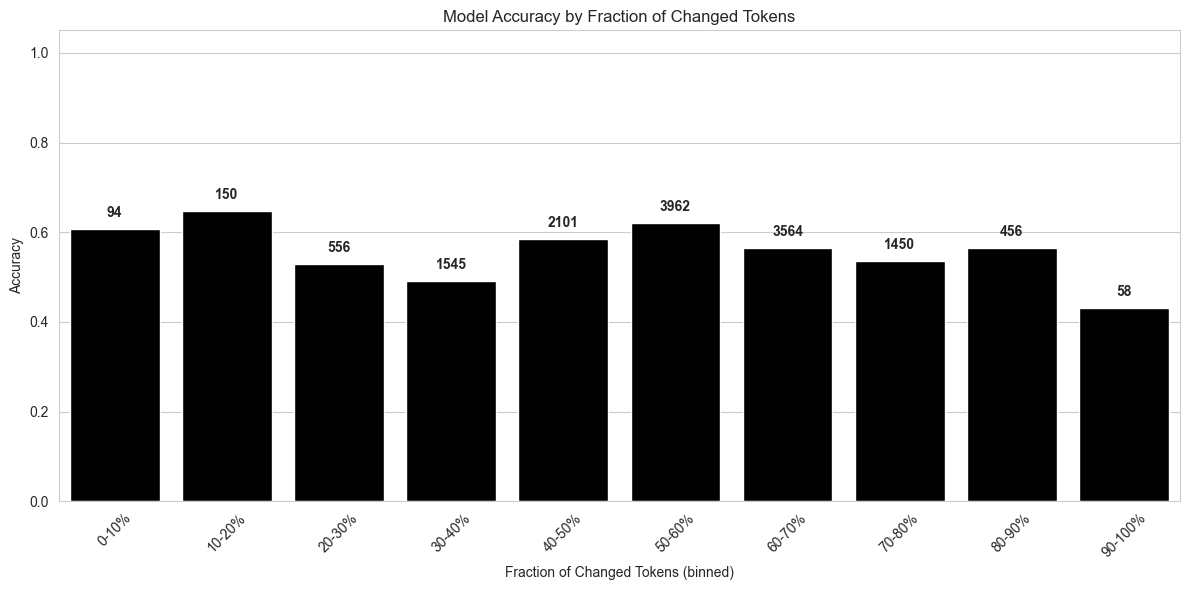

In [9]:
# Create bins for fraction_changed_tokens
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
synonym_preds_df['fraction_bin'] = pd.cut(
    synonym_preds_df['fraction_changed_tokens'],
    bins=bins,
    labels=labels,
    right=False
)

# Calculate accuracy per bin
bin_accuracy = synonym_preds_df.groupby('fraction_bin')['correct_prediction'].mean().reset_index()
# Calculate counts per bin
bin_counts = synonym_preds_df['fraction_bin'].value_counts().reindex(labels)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='fraction_bin', y='correct_prediction', data=bin_accuracy, color='black')

# Annotate counts on top of bars
for i, count in enumerate(bin_counts):
    ax.text(i, bin_accuracy['correct_prediction'][i] + 0.02, str(int(count)), 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel('Fraction of Changed Tokens (binned)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Fraction of Changed Tokens')
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
original_preds_df = pd.DataFrame.from_dict(original_data["predictions"])
synonym_preds_df["original_prediction"] = original_preds_df["prediction"]
synonym_preds_df["correct_original_prediction"] = synonym_preds_df["original_prediction"] == synonym_preds_df["answer"]
synonym_preds_df.head()

,dataset,question,answer,prediction,output,question_metadata,choice_metadata,n_changed_tokens,fraction_changed_tokens,correct_prediction,token_bin,fraction_bin,original_prediction,correct_original_prediction
0,abstract_algebra,Determine the level for the afforded field ext...,B,C,C,"{'n_synsets': [15, 0, 7, 0, 0, 43, 17, 12, 0, ...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'...",3,0.600000,False,2-4,60-70%,D,False
1,abstract_algebra,"Allow P = (1, 2, 5, 4)(2, 3) in S_5 . Ascertai...",C,C,C) 24,"{'n_synsets': [6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'...",4,1.000000,True,2-4,NaN,B,False
2,abstract_algebra,Discover all nothings in the shown finite fiel...,D,C,C,"{'n_synsets': [15, 0, 4, 0, 0, 5, 2, 17, 0, 0,...","[{'n_synsets': [0], 'n_lemmas': [0], 'changes'...",4,0.363636,False,2-4,30-40%,L,False
3,abstract_algebra,Statement 1 | A constituent grouping of a non-...,B,A,A,"{'n_synsets': [7, 0, 0, 0, 7, 3, 0, 0, 0, 0, 0...","[{'n_synsets': [2, 0, 2], 'n_lemmas': [0, 0, 0...",4,0.142857,False,2-4,10-20%,D,False
4,abstract_algebra,Determine the mathematical product of the affo...,B,L,Let's analyze the problem step by step.\n\nGiv...,"{'n_synsets': [15, 0, 6, 0, 0, 43, 1, 0, 0, 43...","[{'n_synsets': [0, 0, 0], 'n_lemmas': [0, 0, 0...",7,0.636364,False,5-9,60-70%,L,False


/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_68673/921493911.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy_original = synonym_preds_df.groupby('fraction_bin')['correct_original_prediction'].mean().reset_index()
/var/folders/dn/rkkxq6wj6tzgm8gxb2zx45hr0000gn/T/ipykernel_68673/921493911.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy_perturbed = synonym_preds_df.groupby('fraction_bin')['correct_prediction'].mean().reset_index()


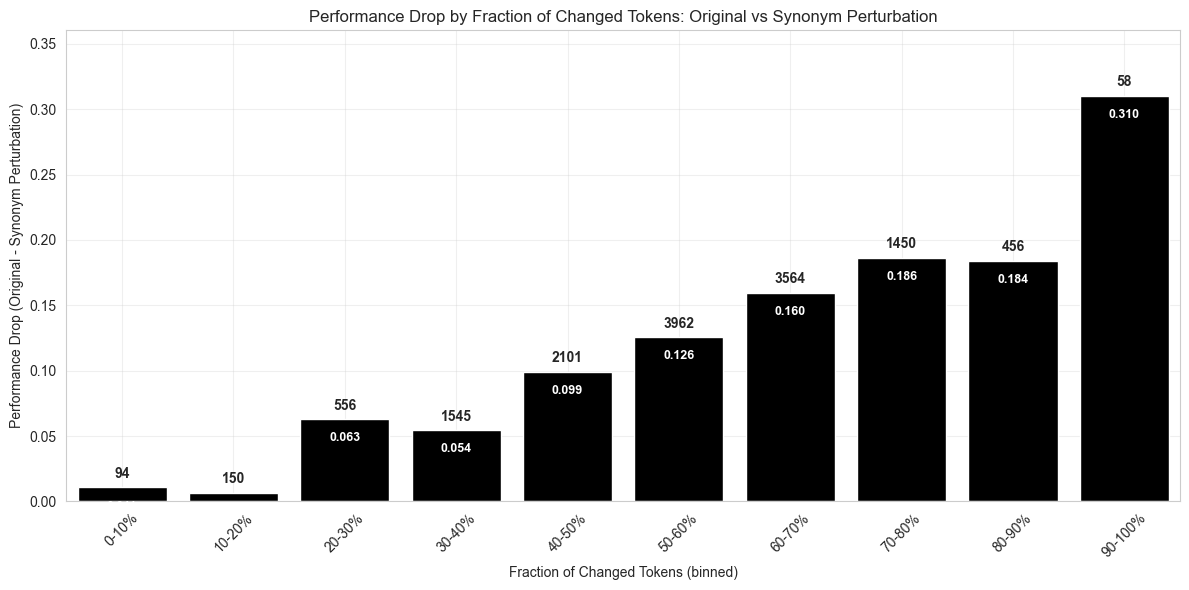

=== PERFORMANCE DROP ANALYSIS ===
Overall performance drop: 0.120
Maximum performance drop: 0.310 (in 90-100% range)
Minimum performance drop: 0.007 (in 10-20% range)
Standard deviation: 0.094


In [11]:
# Create bins for fraction_changed_tokens (replicating the existing approach)
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

# Calculate accuracy per bin for both original and perturbed data
bin_accuracy_original = synonym_preds_df.groupby('fraction_bin')['correct_original_prediction'].mean().reset_index()
bin_accuracy_perturbed = synonym_preds_df.groupby('fraction_bin')['correct_prediction'].mean().reset_index()

# Calculate performance drop (original - perturbed) for each bin
bin_accuracy_original['performance_drop'] = bin_accuracy_original['correct_original_prediction'] - bin_accuracy_perturbed['correct_prediction']

# Calculate counts per bin
bin_counts = synonym_preds_df['fraction_bin'].value_counts().reindex(labels)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='fraction_bin', y='performance_drop', data=bin_accuracy_original, color='black')

# Annotate counts on top of bars
for i, count in enumerate(bin_counts):
    ax.text(i, bin_accuracy_original['performance_drop'][i] + 0.005, str(int(count)), 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add performance drop values on bars
for i, drop in enumerate(bin_accuracy_original['performance_drop']):
    ax.text(i, drop - 0.01, f'{drop:.3f}', 
            ha='center', va='top', fontsize=9, fontweight='bold', color='white')

plt.xlabel('Fraction of Changed Tokens (binned)')
plt.ylabel('Performance Drop (Original - Synonym Perturbation)')
plt.title('Performance Drop by Fraction of Changed Tokens: Original vs Synonym Perturbation')
plt.ylim(0, max(bin_accuracy_original['performance_drop']) + 0.05)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("=== PERFORMANCE DROP ANALYSIS ===")
print(f"Overall performance drop: {bin_accuracy_original['performance_drop'].mean():.3f}")
print(f"Maximum performance drop: {bin_accuracy_original['performance_drop'].max():.3f} (in {labels[bin_accuracy_original['performance_drop'].idxmax()]} range)")
print(f"Minimum performance drop: {bin_accuracy_original['performance_drop'].min():.3f} (in {labels[bin_accuracy_original['performance_drop'].idxmin()]} range)")
print(f"Standard deviation: {bin_accuracy_original['performance_drop'].std():.3f}")


In [12]:
# Ensemble Analysis: Majority Voting across Original, Synonym, and Wrong Sense Perturbations

# Load wrong sense data and create DataFrame
wrong_sense_preds_df = pd.DataFrame.from_dict(wrong_sense_data["predictions"])

# Create a comprehensive ensemble DataFrame
ensemble_df = pd.DataFrame({
    'question_id': original_preds_df.index,
    'answer': original_preds_df['answer'],
    'original_pred': original_preds_df['prediction'],
    'synonym_pred': synonym_preds_df['prediction'],
    'wrong_sense_pred': wrong_sense_preds_df['prediction']
})

# Function to perform majority voting
def majority_vote(row):
    votes = [row['original_pred'], row['synonym_pred'], row['wrong_sense_pred']]
    # Count votes for each option
    vote_counts = {}
    for vote in votes:
        vote_counts[vote] = vote_counts.get(vote, 0) + 1
    
    # Find the option with the most votes
    max_votes = max(vote_counts.values())
    
    # Get all options with maximum votes
    winners = [option for option, count in vote_counts.items() if count == max_votes]
    
    # If there's a tie, we can use different strategies:
    # 1. Return the original prediction (conservative approach)
    # 2. Return the first option alphabetically (deterministic)
    # 3. Return a random choice (non-deterministic)
    
    # Here we'll use the conservative approach: prefer original prediction in case of ties
    if len(winners) > 1:
        if row['original_pred'] in winners:
            return row['original_pred']
        else:
            # If original not in winners, prefer alphabetically first
            return sorted(winners)[0]
    else:
        return winners[0]

# Apply majority voting
ensemble_df['ensemble_pred'] = ensemble_df.apply(majority_vote, axis=1)

# Calculate correctness for each approach
ensemble_df['original_correct'] = ensemble_df['original_pred'] == ensemble_df['answer']
ensemble_df['synonym_correct'] = ensemble_df['synonym_pred'] == ensemble_df['answer']
ensemble_df['wrong_sense_correct'] = ensemble_df['wrong_sense_pred'] == ensemble_df['answer']
ensemble_df['ensemble_correct'] = ensemble_df['ensemble_pred'] == ensemble_df['answer']

# Calculate performance metrics
individual_performance = {
    'Original': ensemble_df['original_correct'].mean(),
    'Synonym Perturbation': ensemble_df['synonym_correct'].mean(),
    'Wrong Sense Perturbation': ensemble_df['wrong_sense_correct'].mean()
}

ensemble_performance = ensemble_df['ensemble_correct'].mean()

print("=== INDIVIDUAL MODEL PERFORMANCE ===")
for model, accuracy in individual_performance.items():
    print(f"{model}: {accuracy:.4f}")

print(f"\n=== ENSEMBLE PERFORMANCE ===")
print(f"Majority Vote Ensemble: {ensemble_performance:.4f}")

print(f"\n=== PERFORMANCE COMPARISON ===")
best_individual = max(individual_performance.values())
print(f"Best Individual Model: {best_individual:.4f}")
print(f"Ensemble Improvement: {ensemble_performance - best_individual:.4f}")
print(f"Relative Improvement: {((ensemble_performance - best_individual) / best_individual * 100):.2f}%")

# Analyze voting patterns
print(f"\n=== VOTING PATTERN ANALYSIS ===")
vote_patterns = ensemble_df[['original_pred', 'synonym_pred', 'wrong_sense_pred']].apply(
    lambda row: tuple(sorted([row['original_pred'], row['synonym_pred'], row['wrong_sense_pred']])), axis=1
)

# Count unanimous vs split decisions
unanimous_count = sum(1 for pattern in vote_patterns if len(set(pattern)) == 1)
split_count = len(vote_patterns) - unanimous_count

print(f"Unanimous decisions: {unanimous_count} ({unanimous_count/len(vote_patterns)*100:.1f}%)")
print(f"Split decisions: {split_count} ({split_count/len(vote_patterns)*100:.1f}%)")

# Analyze which cases benefit from ensembling
print(f"\n=== CASES WHERE ENSEMBLE HELPS ===")
cases_where_ensemble_helps = ensemble_df[
    (ensemble_df['ensemble_correct'] == True) & 
    (ensemble_df['original_correct'] == False)
]
print(f"Cases where ensemble is correct but original is wrong: {len(cases_where_ensemble_helps)}")

cases_where_ensemble_hurts = ensemble_df[
    (ensemble_df['ensemble_correct'] == False) & 
    (ensemble_df['original_correct'] == True)
]
print(f"Cases where ensemble is wrong but original is correct: {len(cases_where_ensemble_hurts)}")

net_benefit = len(cases_where_ensemble_helps) - len(cases_where_ensemble_hurts)
print(f"Net benefit (help - hurt): {net_benefit}")

ensemble_df.head()

=== INDIVIDUAL MODEL PERFORMANCE ===
Original: 0.6992
Synonym Perturbation: 0.5724
Wrong Sense Perturbation: 0.5337

=== ENSEMBLE PERFORMANCE ===
Majority Vote Ensemble: 0.6602

=== PERFORMANCE COMPARISON ===
Best Individual Model: 0.6992
Ensemble Improvement: -0.0390
Relative Improvement: -5.57%

=== VOTING PATTERN ANALYSIS ===
Unanimous decisions: 7584 (54.0%)
Split decisions: 6458 (46.0%)

=== CASES WHERE ENSEMBLE HELPS ===
Cases where ensemble is correct but original is wrong: 239
Cases where ensemble is wrong but original is correct: 786
Net benefit (help - hurt): -547


,question_id,answer,original_pred,synonym_pred,wrong_sense_pred,ensemble_pred,original_correct,synonym_correct,wrong_sense_correct,ensemble_correct
0,0,B,D,C,C,C,False,False,False,False
1,1,C,B,C,B,B,False,True,False,False
2,2,D,L,C,C,C,False,False,False,False
3,3,B,D,A,C,D,False,False,False,False
4,4,B,L,L,L,L,False,False,False,False


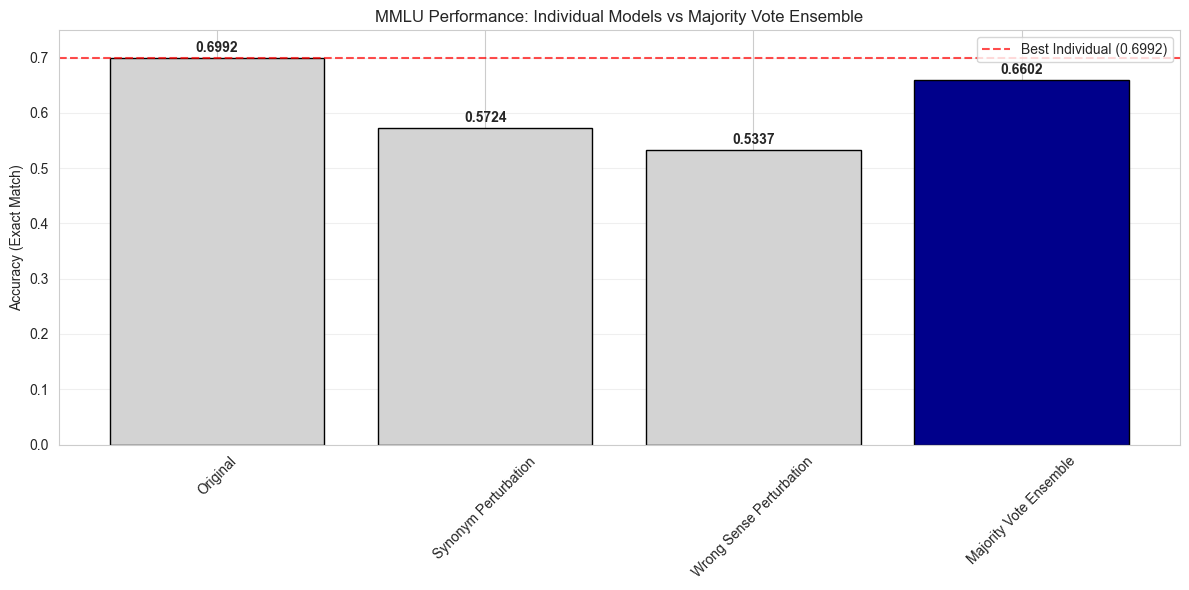


=== DETAILED ENSEMBLE STATISTICS ===
Total questions: 14042
Original accuracy: 0.6992
Synonym perturbation accuracy: 0.5724
Wrong sense perturbation accuracy: 0.5337
Ensemble accuracy: 0.6602
Improvement over best individual: +-0.0390
Improvement over original: +-0.0390


In [13]:
# Visualization: Performance Comparison
plt.figure(figsize=(12, 6))

# Prepare data for visualization
models = ['Original', 'Synonym Perturbation', 'Wrong Sense Perturbation', 'Majority Vote Ensemble']
accuracies = [
    individual_performance['Original'],
    individual_performance['Synonym Perturbation'], 
    individual_performance['Wrong Sense Perturbation'],
    ensemble_performance
]

# Create colors - make ensemble bar stand out
colors = ['lightgray', 'lightgray', 'lightgray', 'darkblue']

# Create the bar plot
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1)

# Add value labels on top of bars
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.005, 
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

# Formatting
plt.ylabel('Accuracy (Exact Match)')
plt.title('MMLU Performance: Individual Models vs Majority Vote Ensemble')
plt.ylim(0, max(accuracies) + 0.05)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()

# Add a horizontal line for the best individual performance
best_individual_line = plt.axhline(y=best_individual, color='red', linestyle='--', alpha=0.7, 
                                  label=f'Best Individual ({best_individual:.4f})')
plt.legend()

plt.show()

# Print detailed ensemble statistics
print(f"\n=== DETAILED ENSEMBLE STATISTICS ===")
print(f"Total questions: {len(ensemble_df)}")
print(f"Original accuracy: {individual_performance['Original']:.4f}")
print(f"Synonym perturbation accuracy: {individual_performance['Synonym Perturbation']:.4f}")
print(f"Wrong sense perturbation accuracy: {individual_performance['Wrong Sense Perturbation']:.4f}")
print(f"Ensemble accuracy: {ensemble_performance:.4f}")
print(f"Improvement over best individual: +{ensemble_performance - best_individual:.4f}")
print(f"Improvement over original: +{ensemble_performance - individual_performance['Original']:.4f}")
